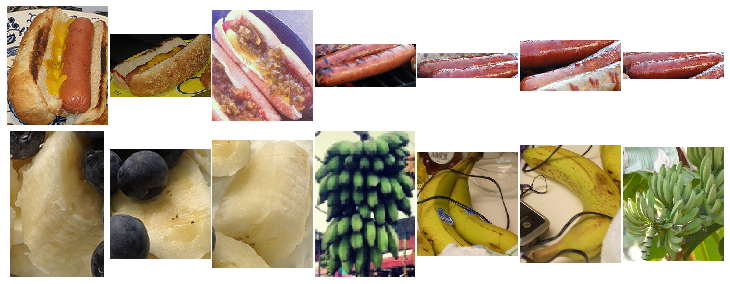

In [1]:
import torch, torchvision
from torch.utils.data import DataLoader
from torch import nn
import os
from img import imgs_show

# http://d2l-data.s3-accelerate.amazonaws.com/hotdog.zip
base_dir = "/home/wushan/Desktop/data/hotdog"
train_dataset = torchvision.datasets.ImageFolder(os.path.join(base_dir,"train"))

positive_examples = [train_dataset[i][0] for i in range(7)]
negative_examples = [train_dataset[-i-1][0] for i in range(7)]

imgs_show(positive_examples+negative_examples, 2)

In [ ]:
from train import train

# We must use the same normalization on training and predicting.
normalize = torchvision.transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
train_aug = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224), # 224 is the fixed input size of ResNet.
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    normalize
])

test_aug = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256), # Scale all images to little bigger than 224.
    torchvision.transforms.CenterCrop(224), # Use center 224
    torchvision.transforms.ToTensor(),
    normalize
])

class PretrainedModel(nn.Module):
    def __init__(self, pretrained= True):
        super().__init__()
        resnet = torchvision.models.resnet18(pretrained = pretrained)
        resnet.fc = nn.Linear(resnet.fc.in_features, 2)
        self.resnet = resnet
    
    def forward(self, x):
        return self.resnet(x)

def create_dataloader(is_train, batch_size, aug):
    data_dir = "train" if is_train else "test"
    dataset = torchvision.datasets.ImageFolder(os.path.join(base_dir, data_dir), aug)
    dataloader = DataLoader(dataset,batch_size, is_train, num_workers=1)
    return dataloader

batch_size, lr, epochs = 32, 0.001, 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_data = create_dataloader(True, batch_size, train_aug)
val_data = create_dataloader(False, batch_size, test_aug)


In [2]:
# Approach 1: Pretrained layers use less learning rate
model = PretrainedModel()
params_1x = [p for name, p in model.resnet.named_parameters() 
                if name not in ["fc.weight", "fc.bias"]]
group_params = [{"params": params_1x},
                {"params": model.resnet.fc.parameters(),"lr": lr * 10}]
# optimizer = torch.optim.Adam(group_params,lr = lr)
optimizer = torch.optim.SGD(group_params, lr = 5e-5, weight_decay = 0.001)

criterion = nn.CrossEntropyLoss(reduction = "none")

train(model, optimizer, criterion, train_data, val_data, epochs, device)

epoch 1/10, loss:7.09, acc:78.00%: 100%|██████████| 63/63 [00:21<00:00,  2.88it/s] 


Validate accuracy at epoch 1: 90.25%


epoch 2/10, loss:4.85, acc:82.72%: 100%|██████████| 63/63 [00:21<00:00,  2.92it/s]


Validate accuracy at epoch 2: 93.50%


epoch 3/10, loss:3.62, acc:85.32%: 100%|██████████| 63/63 [00:21<00:00,  2.90it/s]


Validate accuracy at epoch 3: 90.88%


epoch 4/10, loss:2.94, acc:86.94%: 100%|██████████| 63/63 [00:21<00:00,  2.91it/s]


Validate accuracy at epoch 4: 93.88%


epoch 5/10, loss:2.52, acc:87.93%: 100%|██████████| 63/63 [00:21<00:00,  2.92it/s]


Validate accuracy at epoch 5: 94.62%


epoch 6/10, loss:2.19, acc:88.78%: 100%|██████████| 63/63 [00:21<00:00,  2.92it/s]


Validate accuracy at epoch 6: 94.50%


epoch 7/10, loss:1.95, acc:89.28%: 100%|██████████| 63/63 [00:21<00:00,  2.92it/s]


Validate accuracy at epoch 7: 91.62%


epoch 8/10, loss:1.75, acc:89.72%: 100%|██████████| 63/63 [00:21<00:00,  2.91it/s]


Validate accuracy at epoch 8: 94.50%


epoch 9/10, loss:1.58, acc:90.37%: 100%|██████████| 63/63 [00:21<00:00,  2.91it/s]


Validate accuracy at epoch 9: 94.00%


epoch 10/10, loss:1.45, acc:90.75%: 100%|██████████| 63/63 [00:21<00:00,  2.92it/s]


Validate accuracy at epoch 10: 93.75%


In [4]:
# Approach 2: Freeze pretraining layers. 
# Less performance compare to approach 1. Maybe some other work need to do.
torch.cuda.empty_cache()

model = PretrainedModel()

for name, p in model.resnet.named_parameters() :
    if name not in ["fc.weight", "fc.bias"]:
        p.requires_grad = False

optimizer = torch.optim.SGD(model.parameters(), lr = 5e-4, weight_decay=0.001)


train(model, optimizer, criterion, train_data, val_data, epochs, device)

epoch 1/10, loss:0.52, acc:77.40%: 100%|██████████| 63/63 [00:08<00:00,  7.19it/s]


Validate accuracy at epoch 1: 90.25%


epoch 2/10, loss:0.42, acc:81.50%: 100%|██████████| 63/63 [00:08<00:00,  7.26it/s]


Validate accuracy at epoch 2: 89.88%


epoch 3/10, loss:0.37, acc:83.82%: 100%|██████████| 63/63 [00:08<00:00,  7.20it/s]


Validate accuracy at epoch 3: 92.00%


epoch 4/10, loss:0.35, acc:84.99%: 100%|██████████| 63/63 [00:08<00:00,  7.20it/s]


Validate accuracy at epoch 4: 91.75%


epoch 5/10, loss:0.33, acc:85.93%: 100%|██████████| 63/63 [00:09<00:00,  6.87it/s]


Validate accuracy at epoch 5: 92.75%


epoch 6/10, loss:0.31, acc:86.62%: 100%|██████████| 63/63 [00:08<00:00,  7.09it/s]


Validate accuracy at epoch 6: 92.50%


epoch 7/10, loss:0.30, acc:86.96%: 100%|██████████| 63/63 [00:09<00:00,  6.96it/s]


Validate accuracy at epoch 7: 92.50%


epoch 8/10, loss:0.29, acc:87.53%: 100%|██████████| 63/63 [00:08<00:00,  7.05it/s]


Validate accuracy at epoch 8: 93.00%


epoch 9/10, loss:0.28, acc:87.91%: 100%|██████████| 63/63 [00:08<00:00,  7.08it/s]


Validate accuracy at epoch 9: 93.25%


epoch 10/10, loss:0.28, acc:88.08%: 100%|██████████| 63/63 [00:09<00:00,  6.70it/s]


Validate accuracy at epoch 10: 93.38%
